<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p3/m2p_B01_B_ImageSplines_II_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **M2P: B-Spline Signal Processing Part II - Efficient Design and Implementation**

Micheal Unser, IEEE Tranaction on Signal Processing, Vol 41. No 2. 1993. 
[Download the original paper.](https://ieeexplore.ieee.org/document/193221)
  
 <br/> 
This tutorial is prepared by: [Amey Joshi]() and [Ibraheem Al-Dhamari]()

## Introduction

We summarise the key points mentioned in the companion paper 'B-Spline Signal Processing Part I - Theory'. 

1. Often times it is convenient to transfrom a digital image into a continuous image function. Doing so allows us to use several techniques available for the analysis and processing of continuous functions. For sake of illustration, these ideas were introduced and illustrated on one-dimensional signals.

2. A discrete time/space signal $g[k]$ is approximated by $n$th degree polynomial splines $g^n(x)$. Any such spline can be expressed as a linear combination of the B-splines $\beta^n(x)$. Thus,
$$\tag{1}
g^n(x) = \sum_{k=-\infty}^\infty y[k]\beta^n(x - k).
$$
Therefore, the knowledge of $g^n(x)$ is equivalent to knowing the signal $y[k], k \in \mathbb{Z}$.

3. Discrete B-splines are defined as
$$\tag{2}
b_m^n[k] = \beta^n\left(\frac{k}{m}\right), m \in \mathbb{N}.
$$
Given a discrete signal $g[k]$ the coefficients $y[k]$ of its continuous representation $g^n(x)$ (refer to equation (1)) are given by
$$\tag{3}
y[k] = \left((b_1^n)^{-1} \star g\right)[k].
$$
We assume that the signal $g[k]$ is not severely corrupted by noise. If it were then one should not determine $y[k]$ using equation (3) but should employ some ways to remove the noise. Two approaches were discussed.
  
  a. Use a smoothing spline. Instead of using the filter $(b_1^n)^{-1}$ use the filter $s_\lambda^n$. It is defined through its $z$-transform
  $$\tag{4}
  S_\lambda^n(z) = \frac{1}{B_1^{2r-1}(z) + \lambda(2 - z - z^{-1})^r}.
  $$
  The parameter $\lambda$ controls the extent to which we want to eliminate noise. If $\lambda = 0$ then $s_0^n = b_1^n$. Here $r = (n + 1)/2$.

  b. Use a least square approximation.
  $$\tag{5}
  y[k] = \left(\left(\left(b_m^n \star b_m^n\right)_{\downarrow m}\right)^{-1}\star b_m^n \star g\right)[k]
  $$

4. Once we get $y[k]$ we can determine $g^n(x)$, the continuous representation of $g[k]$, using equation (1). We can carry out signal processing on $g^n(x)$. Finally, when it is time to convert it back to digital format, we use the inverse of equation (3).
$$\tag{6}
\hat{g}[k] = (b_1^p \star y)[k].
$$
Note that we have used a spline of degree $p$ to convey the point that it need not match the degree $n$ used while generating the continuous representation.

The theoretical analysis presented so far assumed that $g[k] \in l_2$. That is, we were given a signal of infinite extent and of finite amplitude. Real world signals satisfy the second condition but not the first. In order to extend them into true sequences, we use the standard technique of replicating them on either side *ad infinitum*. That is
$$\tag{7}
\begin{eqnarray}
g[-k] &=& g[k + 1], k = 0, \ldots K-1 \\
g[k]  &=& g[2K - k], k = K, \ldots, 2K-1
\end{eqnarray}
$$
where $K$ is the duration of the signal. That is, we are given just $g[1], \ldots, g[K]$. For all $k \in \mathbb{Z}$, we have
$$\tag{8}
g[k] = g[k\mod(2K-1)].
$$

## B-spline filter implementation

### Basic decomposition formulae
Consider a general symmetric, stable recursive filter of order $2N$ whose transfer function is
$$\tag{1}
H_{2N}(z) = \frac{c_0}{z^N + z^{-N} + \left(\sum_{k=1}^{N-1}a_k(z^k + z^{-k})\right) + a_0} = \frac{N}{D},
$$
where $c_0, a_0, \ldots a_{N-1}$ are constant coefficients. The symbols $N$ and $D$ denote the numerator and the denominator. Let
$$\tag{2}
P_{2N}(z) = z^ND = z^{2N} + a + \left(\sum_{k=1}^{N-1}a_k(z^{N+k} + z^{N-k})\right) + a_0z^N.
$$
The polynomial $P_{2N}$ satisfies the relation
$$\tag{3}
z^{-N}P_{2N}(z) = z^NP_{2N}(z^{-1}).
$$
From equation (3) it is evident that if $z$ is a zero of $P_{2N}$ then so is $z^{-1}$. Thus, all zeros of $P_{2N}$ occur in pairs that are reciprocals of each other. If $(z_i, z_i^{-1})$ is one such pair then it contributes to $P_{2N}(z)$ through factors $(z - z_i)$ and $(z - z_i^{-1})$. That is, each such pair contributes
$$\tag{4}
P_i = (z - z_i)(z - z_i^{-1}) = -zz_i^{-1}(1 - z^{-1}z_i)(1 - zz_i)
$$
so that 
$$\tag{5}
P_{2N}(z) = \prod_{i=1}^NP_i = z^{N}\prod_{i=1}^N(-z_i)^{-1}(1 - z^{-1}z_i)(1 - zz_i).
$$
On comparing equations (2) and (5) we get
$$\tag{6}
D = \prod_{i=1}^N(-z_i)^{-1}(1 - z^{-1}z_i)(1 - zz_i).
$$
We can then write equation (1) as
$$\tag{7}
H_{2N}(z) =c_0\prod_{i=1}^NH(z;z_i),
$$
where
$$\tag{8}
H(z;z_i) = \frac{1}{D} = \frac{-z_i}{(1 - z^{-1}z_i)(1 - zz_i)}.
$$
Using the method of partial fractions, we can write
$$\tag{9}
H(z;z_i) =\frac{z_i}{(1 -z_i^2)}\left(\frac{1}{1 - z_iz^{-1}} + \frac{1}{1 - z_iz} - 1\right).
$$


### Implementation of the basic symmetrical operator
Let us assume, for sake of this section, that all roots $z_i$ are real. In order to implement a filter with transfer function given by equation (1) of the previous section, we first find the inverse $z$-transform of $H(z; z_i)$ given by equation (9). It is given by
$$\tag{1}
h[n; z_i] = \frac{1}{2\pi i}\oint_C H(z, z_i)z^{n-1}dz,
$$
where $C$ is a contour that encloses the origin and all poles of $H(z, z_i)$. Let us, therefore, take $C$ to be the circle or radius $1$ more than the absolute value of the largest root of $P_{2N}(z)$. Thus,
$$\tag{2}
h[n; z_i] = \frac{z_i}{1 - z_i^2}\frac{1}{2\pi i} \oint_C\left(\frac{1}{1 - z_iz^{-1}} + \frac{1}{1 - z_iz} - 1\right)z^{n-1}dz.
$$
In order to evaluate this integral we use the residue theorem
$$\tag{3}
\frac{1}{2\pi i}\oint_C f(z)dz = \sum_{a}\text{Res}(f, a),
$$
where the sum is over all poles of $f$ and $\text{Res}(f, a)$ is the residue of the function $f$ at $a$. Consider the first integral,
$$\tag{4}
\frac{1}{2\pi i}\oint_C\frac{z^{n-1}}{1 - z_iz^{-1}}dz = \frac{1}{2\pi i}\oint_C\frac{z^n}{z - z_i}dz = z_i^n.
$$
This term corresponds to the root $z_i$. The term that corresponds to the root $1/z_i$ is
$$\tag{5}
\frac{1}{2\pi i}\oint_C\frac{z^{n-1}}{1 - z_iz}dz = -z_i^{-1}\oint_C\frac{z^{n-1}}{z - z_i^{-1}}dz = -z_i^{-1}(z_i^{-1})^{n-1} =\left(\frac{1}{z_i}\right)^{n}.
$$
The last term is $1$ only if $n = 0$. It is zero otherwise. Thus, we can consolidate these observations to conclude that
$$\tag{6}
h[n;z_i] = \frac{z_i}{1 - z_i^2}z_i^{|n|}.
$$
We can implement the recursive filter corresponding to equation (9) of the previous section, or equivalently equation (6) in this section using the following algorithm.
$$\tag{7}
\begin{eqnarray*}
y^+[k] &=& x[k] + z_iy^+[k-1], k = 2, \ldots, K \\
y[K] &=& c_i(2y^+[K] - x[K]) \\
y[k] &=& z_i(y[k+1] - y^+[k]), k = 1, \ldots, K-1
\end{eqnarray*}
$$
where
$$\tag{8}
c_i = \frac{z_i}{1 - z_i^2}.
$$
In order to calculate $y[k]$, we need

- One addition and one multiplication in the third of equations (7).
- One more addition and multiplication in the first of equations (7).
- Note that the second of the equations (7) is just a special case of the third.

In short, we need two additions and two multiplications for every output value. Thus, this algorithm has a linear complexity.

### Recursive direct B-spline filters

The direct B-spline filters are defined by the following equations, first mentioned in the Part I of this paper.

$$\tag{1}
\begin{eqnarray*}
nb_m^n[k] &=& \left(\frac{k}{m} + \frac{n+1}{2}\right)c_m^{n-1}[k] + \left(\frac{n+1}{2} - \frac{k}{m}\right)c_m^{n-1}[k-m] \\
nc_m^n[k] &=& \left(\frac{k}{m} + \frac{n+2}{2}\right)b_m^{n-1}[k+m] + \left(\frac{n}{2} - \frac{k}{m}\right)b_m^{n-1}[k]
\end{eqnarray*}
$$
subject to the initial conditions
$$\tag{2}
b_m^0[k] = \begin{cases}
1 & \text{ if } -m/2 \le k \le m/2 \\
0 & \text{ otherwise.}
\end{cases}
$$
and
$$\tag{c}
c_m^0[k] = \begin{cases}
1 & \text{ if } 1 - m \le k \le 0 \\
0 & \text{ otherwise.}
\end{cases}
$$

In the previous tutorial we had written code to compute the filters for $n = 1$. We will now present code to compute the general case.

In [0]:
def b(n, m, k):
  if n == 0:
    if -m/2 <= k and k <= m/2:
      rv = 1
    else:
      rv = 0
  else:
    rv = ((k/m + (n + 1)/2) * c(n-1, m, k) + ((n + 1)/2 - k/m) * c(n - 1, m, k - m))/n

  return rv

def c(n, m, k):
  if n == 0:
    if 1 - m <= k and k <= 0:
      rv = 1
    else:
      rv = 0
  else:
    rv = ((k/m + (n + 2)/2) * b(n - 1, m, k + m) + (n/2 - k/m) * b(n - 1, m, k))/n

  return rv

One can test the code using the following snippet in the cell below this one. Note that for sake of neatness, we are rounding off the filter coefficients to three decimal places while printing them.


In [9]:
import numpy as np

print(f'b(0, 1, 0) = ' + str(b(0, 1, 0)))
for n in range(0, 6):
  for k in range(-n, n + 1):
    print(f'b({n}, {1}, {k}) = {np.round(b(n, 1, k), 3)}  ')

print(f'c(0, 1, 0) = ' + str(c(0, 1, 0)))
for n in range(0, 6):
  for k in range(-n, n + 1):
    print(f'c({n}, {1}, {k}) = {np.round(c(n, 1, k), 3)}  ')

b(0, 1, 0) = 1
b(0, 1, 0) = 1  
b(1, 1, -1) = 0.0  
b(1, 1, 0) = 1.0  
b(1, 1, 1) = 0.0  
b(2, 1, -2) = 0.0  
b(2, 1, -1) = 0.125  
b(2, 1, 0) = 0.75  
b(2, 1, 1) = 0.125  
b(2, 1, 2) = 0.0  
b(3, 1, -3) = 0.0  
b(3, 1, -2) = 0.0  
b(3, 1, -1) = 0.167  
b(3, 1, 0) = 0.667  
b(3, 1, 1) = 0.167  
b(3, 1, 2) = 0.0  
b(3, 1, 3) = 0.0  
b(4, 1, -4) = 0.0  
b(4, 1, -3) = 0.0  
b(4, 1, -2) = 0.003  
b(4, 1, -1) = 0.198  
b(4, 1, 0) = 0.599  
b(4, 1, 1) = 0.198  
b(4, 1, 2) = 0.003  
b(4, 1, 3) = 0.0  
b(4, 1, 4) = 0.0  
b(5, 1, -5) = 0.0  
b(5, 1, -4) = 0.0  
b(5, 1, -3) = 0.0  
b(5, 1, -2) = 0.008  
b(5, 1, -1) = 0.217  
b(5, 1, 0) = 0.55  
b(5, 1, 1) = 0.217  
b(5, 1, 2) = 0.008  
b(5, 1, 3) = 0.0  
b(5, 1, 4) = 0.0  
b(5, 1, 5) = 0.0  
c(0, 1, 0) = 1
c(0, 1, 0) = 1  
c(1, 1, -1) = 0.5  
c(1, 1, 0) = 0.5  
c(1, 1, 1) = 0.0  
c(2, 1, -2) = 0.0  
c(2, 1, -1) = 0.5  
c(2, 1, 0) = 0.5  
c(2, 1, 1) = 0.0  
c(2, 1, 2) = 0.0  
c(3, 1, -3) = 0.0  
c(3, 1, -2) = 0.021  
c(3, 1, -1) = 0.479  
c(3, 1,

The values $b(2, 1, -2), b(2, 1, -1), b(2, 1, 0), b(2, 1, 1), b(2, 1, 2)$ and $b(2, 1, 3)$ are the values of the filter $b_1^2$ at  points $x = -2, -1, 0, 1, 2$. Therefore, we can write
$$
b_1^2 = [0, 
$$

### First order smoothing spline filter

Equation (23) of the section 'Smoothing Splines' in the previous tutorial derived the transfer function for a smoothing spline filter of order $r$ as
$$\tag{1}
Y(z) = \frac{G(z)}{B_1^{2r-1}(z) + \lambda (2 - z - z^{-1})^r}.
$$ 
If we restrict ourselved to $r = 1$, we get
$$\tag{2}
Y(z) = \frac{G(z)}{B_1^{1}(z) + \lambda (2 - z - z^{-1})}.
$$ 
However, $B_1^1(z) = 1$ as table I in the [paper](https://ieeexplore.ieee.org/document/193220) shows. Therefore, the transfer function of the first order smoothing spline filter is
$$\tag{3}
Y(z) = \frac{G(z)}{1 + \lambda (2 - z - z^{-1})}.
$$ 
Recall that $\lambda$ is the regularization parameter. It determines how important is smoothing in our filter. $\lambda = 0$ means that there is no smoothing. We can further simplify it to be
$$\tag{4}
Y(z) = \frac{z}{-\lambda z^2 + (2\lambda + 1)z - \lambda}G(z).
$$
The denominator is a quadratic and its roots are
$$\tag{5}
z = 1 + \frac{1}{2\lambda} \pm \frac{4\lambda + 1}{2\lambda}.
$$
The smaller of the two roots is the one with the negative sign. We call it $z_1$. 
$$\tag{6}
z_1 = 1 + \frac{1}{2\lambda} - \frac{4\lambda + 1}{2\lambda}.
$$
It is a particular case of the filter given by equation (7) in the section 'Basic decomposition formulae' with $c_0 = -\lambda^{-1}$ and $N=1$.

### Least squares spline filter

The least square filter is given by equation (4.18) of the companion [paper](https://ieeexplore.ieee.org/document/193220)
$$\tag{1}
y[k] = (s_m^n \star (b_m^n \star g)_{\downarrow m})[k].
$$
This suggests that the least square spline filter involves three steps.

1. Filtering by $b_m^n$.
2. Decimation by a factor of $m$.
3. Applying the least squares filter $s_m^n$.

### Comparison with conventional matrix approaches

It is possible to implement the B-spline filtering operations using matrices instead of filters. However, the filter approach is superior because

- the boundary conditions are more transparent in the algorithm and
- the computational complexity is $O(N)$ instead of $O(N^2)$ for the matrix computations. Note that matrix computations are possible in $O(N^2)$ because of the block Toeplitz form of the matrices. Without their special form the algorithm would have had an $O(N^3)$ complexity. Here $N$ is the size of the signal.

The superiority of $O^(N)$ algorithm over $O(N^2)$ is evident when one considers the size of a typical image as a $512 \times 512$ matrix.


## B-spline approximation and low-pass filtering

We can interpret a B-spline filter as a low-pass filter. Recall the cardinal cubic spline and its frequency response from the companion paper. It was defined as 
$$\tag{1}
\eta^3(x) = \frac{-6\alpha}{1 - \alpha^2}\sum_{k=-\infty}^\infty \alpha^{|k|}\beta^3(x - k),
$$
where $\alpha = \sqrt{3} - 2$ and $\beta^3$ is a cubic B-spline. We show its form and frequency response in the code snippet below.



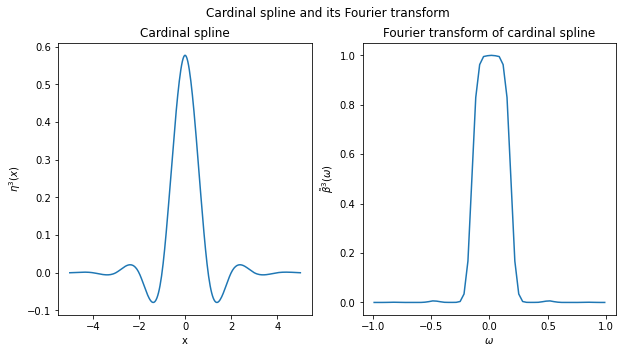

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt

def mu(x):
    y = np.ones(len(x))
    si = np.where(x < 0)[0]
    y[si] = 0

    return y

def beta3(x):
    b_0 = np.multiply(pow(x + 2, 3), mu(x + 2))/6
    b_1 = -2/3 * np.multiply(pow(x + 1, 3), mu(x + 1))
    b_2 = np.multiply(pow(x, 3), mu(x))
    b_3 = -2/3 * np.multiply(pow(x - 1, 3), mu(x - 1))
    b_4 = np.multiply(pow(x - 2, 3), mu(x - 2))/6

    return b_0 + b_1 + b_2 + b_3 + b_4

alpha = math.sqrt(3) - 2

def eta(x):
    sum = 0
    for k in range(-5, 6):
        sum = sum + math.pow(alpha, abs(k)) * beta3(x - k)

    return sum

x = np.linspace(-5, 5, 300)
y = eta(x)

cf = np.abs(np.fft.fft(y))
# Normalize it.
cf1 = np.fft.fftshift(cf)/np.max(cf)

fig = plt.figure(figsize = (10, 5))
fig.suptitle('Cardinal spline and its Fourier transform')
p1 = plt.subplot(121)
p1.set_title('Cardinal spline')
plt.plot(x, y, label = r'$\eta^3(x)$')
plt.xlabel('x')
plt.ylabel(r'$\eta^3(x)$')

left = 120
right = 180
p2 = plt.subplot(122)
p2.set_title('Fourier transform of cardinal spline')
plt.plot(x[left:right], cf1[left:right], label = r'$\tilde{\eta}^3$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\tilde{\beta}^3(\omega)$')
plt.show()

From the frequency response it is evident that only a small band of frequencies in the neighbourhood of zero get a non-zero response from the filter. A cardinal cubic spline filter is indeed like an ideal low-pass filter. Can we interpret the other spline operations as low-pass filters as well?


### Smoothing spline approximation

From equation (4.13) of the [companion paper](https://ieeexplore.ieee.org/document/193220), the transfer function of the smoothing spline is
$$\tag{1}
H_\lambda^n(z) = \frac{B_1^n(z)}{B_1^n(z) + \lambda(-z+2-z)^{(n+1)/2}},
$$
where $\lambda$ is a smoothing parameter. If we choose $n=3$, $$\tag{2}
B_1^3(z) = \frac{z + 4 + z^{-1}}{6}
$$
so that
$$\tag{3}
H_\lambda^3(z) = \frac{z + 4 + z^{-1}}{z + 4 + z^{-1} + 6\lambda(-z + 2 + z^{-1})^2}.
$$
It can be simplified to
$$\tag{4}
H_\lambda^3(z) =\frac{z + 4z^2 + z^3}{6\lambda + (1-24\lambda)z + 4(1 + 9\lambda)z^2 + (1 - 24\lambda)z^3 + 6\lambda z^5}.
$$
The frequency response of this filter is shown in the code snippet below.

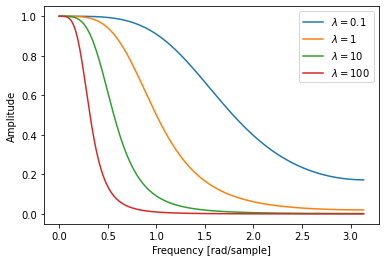

Freqency response of a smoothing spline filter.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def compute_a(_lambda):
  return [6*_lambda, 1 - 24*_lambda, 4*(1 + 9*_lambda), 1 - 24*_lambda, 6*_lambda]

b = [0, 1, 4, 1]

def get_freq_response(_lambda):
  a = compute_a(_lambda)
  w, h = signal.freqz(b, a)
  plt.plot(w, abs(h), label = rf'$\lambda = {_lambda}$')

all_lambdas = [0.1, 1, 10, 100]
for _lambda in all_lambdas:
  get_freq_response(_lambda)

plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
print('Freqency response of a smoothing spline filter.')

### Least squares spline approximation

Step 1 of the least squares filtering is also called the pre-filtering step. Its frequeny response for $n=3$ and $m=2$ is
$$\tag{1}
\mathring{H}_2^3(z) = 8\frac{(4+z^2+z^{-2})(32 + 23(z+z^{-1}) + 8(z^2+z^{-2})+(z^3+z^{-3})}{2212 + 1087(z^2+z^{-2}) + 110(z^4+z^{-4}) + (z^6+z^{-6})}.
$$
It can be simplified to
$$\tag{2}
\mathring{H}_2^3(z) = \frac{8z+64z^2+216z^3+512z^4+928z^5+1152z^6+928z^7+512z^8+216z^9+64z^{10}+8z^{11}}{1+110z^2+1087z^4+2216z^6+1087z^8+110z^{10}+z^{12}}.
$$
We show its frequency response below.

No handles with labels found to put in legend.


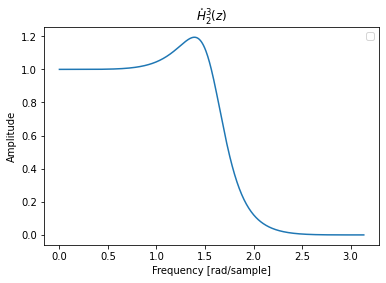

Frequency response of an optimal pre-filter.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

b = [0, 8, 64, 216, 512, 928,1152, 928, 512, 216, 64, 8]
a = [1, 0, 110, 0, 1087, 0, 2216, 0, 1087, 0, 110, 0, 1]

w, h = signal.freqz(b, a)
plt.plot(w, abs(h))

plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude')
plt.legend()
plt.title(r'$\mathring{H}_2^3(z)$')
plt.show()
print('Frequency response of an optimal pre-filter.')

## Cubic spline image processing

### Gradient and laplacian operators
We use these operations for detect edges in an image. In order to do so on continuous representations, we 

1. Apply a cubic spline filter to get the continuous representation.
2. Apply a vertical or a horizontal gradient to get the first derivative. 
3. Alternatively, we can apply the laplacian as well.

One can build these operators using the tensor product of 1-d operators. The tensor product is implemented in python by the function 'outer' in the module numpy. We illustrate these steps in the three code snippets below.

The vertical gradient filter is
$$\tag{1}
\nabla_v = \frac{1}{12}\begin{pmatrix}1 \\ 0 \\ -1\end{pmatrix}\otimes\begin{pmatrix}1 & 4 & 1\end{pmatrix} = \frac{1}{12} \begin{pmatrix}1 & 4 & 1 \\ 0 & 0 & 0 \\ -1 & 4 & -1\end{pmatrix}.
$$

The horizontal gradient filter is 
$$\tag{2}
\nabla_h = \frac{1}{12}\begin{pmatrix}1 \\ 4 \\ 1\end{pmatrix}\otimes\begin{pmatrix}1 & 0 & -1\end{pmatrix} = \frac{1}{12} \begin{pmatrix}1 & 0 & -1 \\ 4 & 0 & -4 \\ 1 & 0 & -1\end{pmatrix}.
$$

The cubic spline filter is
$$\tag{3}
\frac{1}{6}\begin{pmatrix}1 \\ 4 \\ 1\end{pmatrix}\otimes\frac{1}{6}\begin{pmatrix} 1 & 4 & 1 \end{pmatrix} = \frac{1}{36}\begin{pmatrix}1 & 4 & 1 \\ 4 & 16 & 4 \\ 1 & 4 & 1\end{pmatrix}
$$
Finally, the laplacian mentioned in the paper is
$$\tag{4}
\Delta = \begin{pmatrix}1 \\ -2 \\ 1\end{pmatrix}\otimes\begin{pmatrix} 1 & -2 & 1\end{pmatrix} = \begin{pmatrix}1 & -2 & 1 \\ -2 & 4 & -2 \\ 1 & -2 & 1\end{pmatrix}.
$$
However, it is quite different from the one we normally use in image processing,
$$\tag{5}
\Delta_s = \begin{pmatrix}0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{pmatrix}.
$$
We will demonstrate both.

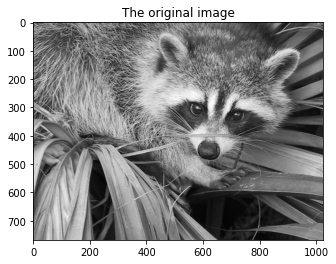

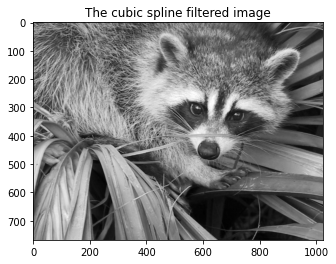

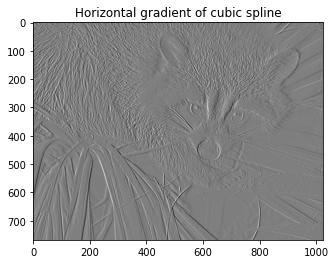

In [13]:
# Horizontal gradient of a cubic spline filtered image.

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)
grad_h = np.array([[1, 0, -1], [4, 0, -4], [1, 0, -1]])/12

# Cubic spline filtered
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
df1 = signal.convolve2d(f1, grad_h, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The cubic spline filtered image')
display_image(df1, 'Horizontal gradient of cubic spline')

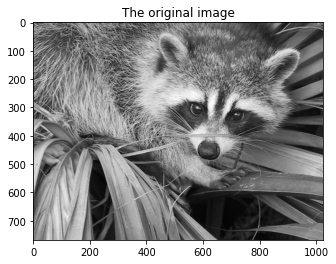

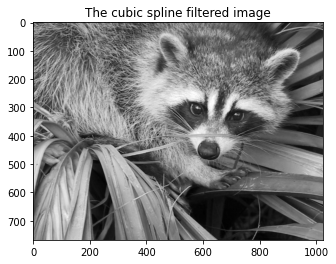

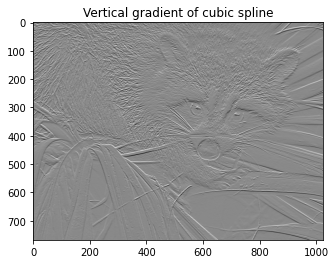

In [14]:
# Vertical gradient of a cubic spline filtered image.

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)
grad_v = np.array([[1, 4, 1], [0, 0, 0], [-1, -4, -1]])/12

# Cubic spline filtered
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
df1 = signal.convolve2d(f1, grad_v, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The cubic spline filtered image')
display_image(df1, 'Vertical gradient of cubic spline')

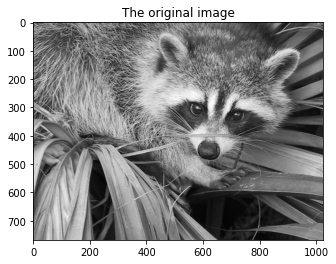

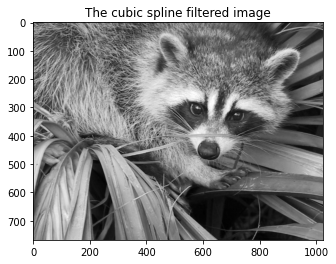

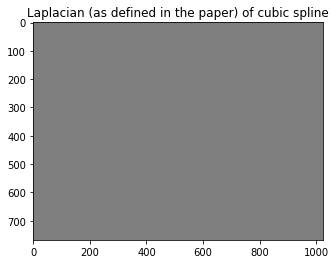

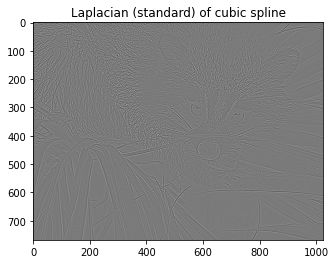

In [15]:
# Laplacian of a cubic spline filtered image.

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)
laplacian = np.outer([1, -2, 1], [1, -2, 1])

# Cubic spline filtered
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
df1 = signal.convolve2d(f1, laplacian, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The cubic spline filtered image')
display_image(df1, 'Laplacian (as defined in the paper) of cubic spline')

laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
df1 = signal.convolve2d(f1, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian (standard) of cubic spline')


### Smoothing cubic spline filter

The smoothing cubic spline filter implemented in the paper has transfer function
$$\tag{1}
S_\lambda^3(z) = \frac{6}{z+4+z^{-1} + 6\lambda(z^{-2}-4z^{-1}+6-4z+z^2)}.
$$

The impulse response of this filter is
$$\tag{2}
s_\lambda^3[k] = c_0\rho^{|k|}\left(\cos(\omega |k|) + \gamma\sin(\omega |k|)\right),
$$
where
$$
\begin{eqnarray*}
\xi &=& 1 - 96\lambda + 24\lambda\sqrt{3 + 144\lambda} \\
\tan(\omega) &=& \sqrt{\frac{144\lambda - 1}{\xi}} \\
\rho &=& \left(\frac{24\lambda - 1 - \sqrt{\xi}}{24\lambda}\right)\left(\frac{48\lambda + 24\lambda\sqrt{3 + 144\lambda}}{\xi}\right)^{1/2} \\
\gamma &=& \frac{1 - \rho^2}{1 + \rho^2}\cdot\cot(\omega) \\
c_0 &=& \frac{1 + \rho^2}{1 - \rho^2}\cdot\frac{1 - 2\rho\cos\omega + \rho^2}{1 + 2\rho\cos\omega + \rho^2}.
\end{eqnarray*}
$$
All these constants can be found from $\lambda$. We will implement this filter for $\lambda = 10$.



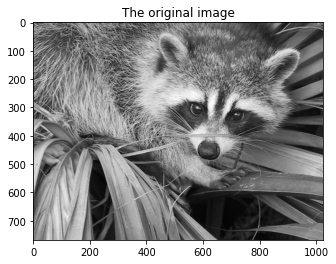

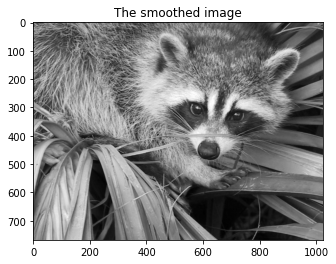

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

lmbd = 10
xi = 1 - 96*lmbd + 24 * lmbd * math.sqrt(3 + 144*lmbd)

# Calculate rho
rho1 = (24*lmbd - 1 - math.sqrt(xi))/(24 * lmbd)
rho2 = (48*lmbd + 24*lmbd*math.sqrt(3 + 144*lmbd))/xi
rho = rho1 * math.sqrt(rho2)

# Calculate omega
omega = math.atan(math.sqrt((144 * lmbd - 1)/xi))

gamma = ((1 - rho**2)/(1 + rho**2)) * math.sqrt(xi/(144 * lmbd - 1))
c0 = ((1 + rho**2)/(1 - rho**2)) * ((1 - 2 * rho * math.cos(omega) + rho**2)/(1 + 2 * rho * math.cos(omega) + rho**2))

# Compute the 1-d filter
s = [c0 * rho * (math.cos(omega) + gamma * math.sin(omega)),
     c0 * 1.0 * 1,
     c0 * rho * (math.cos(omega) + gamma * math.sin(omega))]

# Compute the 2-d filter
s2 = np.outer(s, s)

img = misc.face(gray=True).astype(np.float32)
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The smoothed image')

### Cubic spline pyramid

Often times we want a multi-resolution pyramid of an image. It is observed that if we apply a cubic spline smoothing filter to each level of decimation we obtain a hierarchy of images that retain sharpness better than other methods. The code snippet below shows the hierarchical application of cubic spline filter.

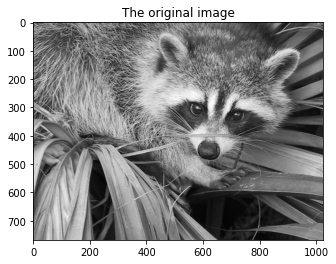

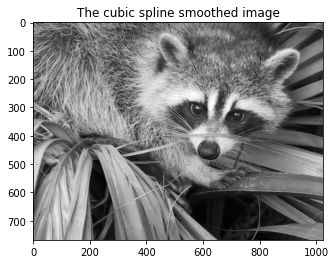

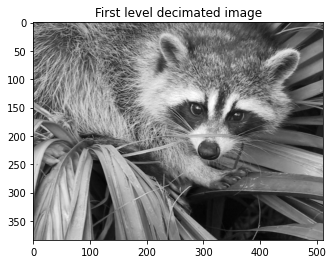

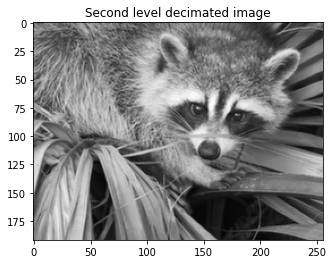

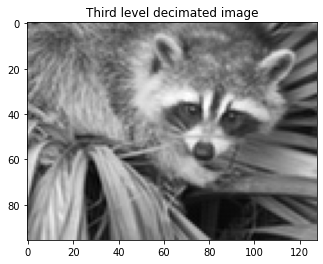

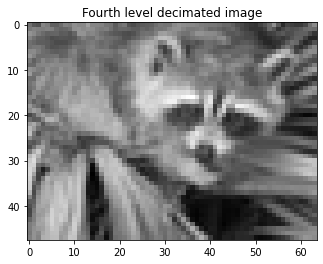

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

# Build the cubic B-spline filter
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

img = misc.face(gray=True).astype(np.float32)
display_image(img, 'The original image')
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
display_image(f1, 'The cubic spline smoothed image')

# First level of decimation
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'First level decimated image')

# Second level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'Second level decimated image')

# Third level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'Third level decimated image')

# Fourth level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'Fourth level decimated image')

We can also apply a laplacian at each level and observe that edges are visible to an increasing extent at higher levels of the pyramid.

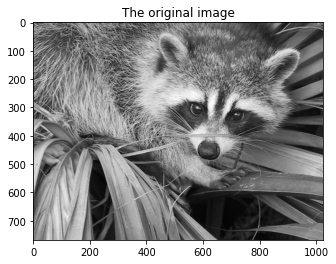

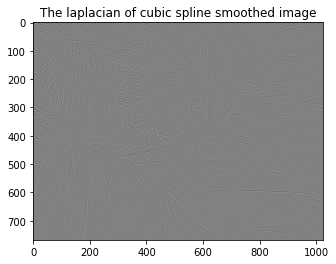

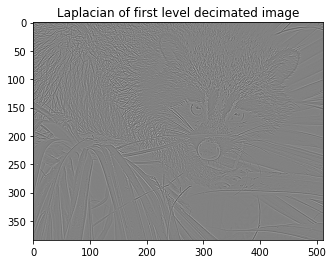

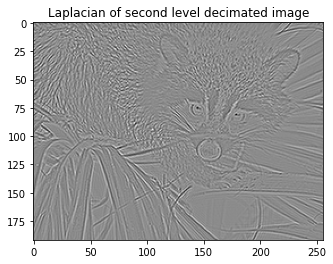

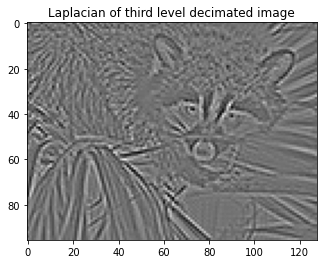

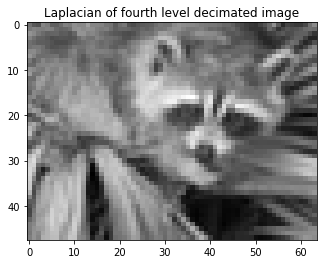

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

# Build the cubic B-spline filter
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)

# Build the laplacian filter
# laplacian = np.outer([1, -2, 1], [1, -2, 1])
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

img = misc.face(gray=True).astype(np.float32)
display_image(img, 'The original image')
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
df1 = signal.convolve2d(img, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'The laplacian of cubic spline smoothed image')

# First level of decimation
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian of first level decimated image')

# Second level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian of second level decimated image')

# Third level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian of third level decimated image')

# Fourth level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(fxy, 'Laplacian of fourth level decimated image')

# Conclusion

The key takeaways of this paper are


1.   Cubic spline interpolation can be done either as an operation of filters or as matrix computations. The former method is computationally and conceptually superior than the latter one.
2.   A cubic spline filter is a low pass filter. We demonstrated it by producing smoothened images. We also plotted frequency response of a variety of spline filters and saw that they indeed are low pass filters.
3.   We showed how to compute derivatives in the spline domain. 
4.   We demonstrated smoothing splines to detect edges at various levels of resolution.



# Appendix A - Convergence of the least squares filters
The least squares B-spline filter is defined as 
$$\tag{1}
s_m^n[k] = \left((b_m^n \star b_m^n)_{\downarrow m}\right)^{-1}[k].
$$
In order to consider the limit of this operator as $m \rightarrow \infty$ we use the definition of convolution and consider the limit
$$\tag{2}
L = \lim_{m \rightarrow \infty}\left(\frac{1}{m}\sum_{l=-\infty}^\infty b_m^n[l]b_m^n[k - l]\right)
$$
In terms of the continuous spline functions of degree $n$,
$$\tag{3}
L = \lim_{m \rightarrow \infty}\left(\frac{1}{m}\sum_{l=-\infty}^\infty \beta^n\left(\frac{l}{m}\right)\beta^n\left(x - \frac{l}{m}\right)\right)
$$
We can now write the sum as an integral
$$\tag{4}
L = \lim_{m \rightarrow \infty}\int_{-\infty}^\infty \beta^n\left(\frac{l}{m}\right)\beta^n\left(x - \frac{l}{m}\right)dy = \lim_{m \rightarrow \infty}\beta^{2n+1}\left(\frac{k}{m}\right),
$$
where we have used the convolution property of B-splines. By the definition of the discrete spline,
$$\tag{5}
L = \lim_{m \rightarrow \infty}b_m^{2n+1}[k].
$$
If we downsample this signal at the rate $m$, we get $b_1^{2n+1}[k]$, which is hte desired limit.